# model

In [79]:
import torch.nn as nn
import torchvision.models as models
import torch.nn.functional as F


class HSVColorizationNet(nn.Module):
    def __init__(self, input_channels=1):
        super(HSVColorizationNet, self).__init__()

        # ResNet-18
        resnet = models.resnet18(num_classes=1000)
        resnet.conv1.weight = nn.Parameter(resnet.conv1.weight.sum(dim=1).unsqueeze(1))
        self.midlevel_resnet = nn.Sequential(*list(resnet.children())[:6])

        # upsampling layers
        self.conv1 = nn.Conv2d(128, 64, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64, 64, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 32, 3, padding=1)
        self.bn3 = nn.BatchNorm2d(32)
        self.conv4 = nn.Conv2d(32, 16, 3, padding=1)
        self.bn4 = nn.BatchNorm2d(16)
        self.conv5 = nn.Conv2d(16, 2, 3, padding=1)

    def forward(self, input):
        # Mid-level features from ResNet
        midlevel_features = self.midlevel_resnet(input)

        # upsample block
        x = F.relu(self.bn1(self.conv1(midlevel_features)))
        x = F.interpolate(x, scale_factor=2, mode='nearest')
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.interpolate(x, scale_factor=2, mode='nearest')
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.relu(self.bn4(self.conv4(x)))
        x = self.conv5(x)
        x = F.interpolate(x, scale_factor=2, mode='nearest')

        return x


# colorize data

In [80]:
import torchvision.transforms as T
import torch
from torchvision import datasets
from torchvision.datasets.folder import default_loader
from skimage.color import rgb2hsv, hsv2rgb, rgb2gray
import numpy as np

class ColorizeDataHSV(datasets.ImageFolder):
    def __init__(self, root, transform=None, target_transform=None, loader=default_loader, is_train=True):
        super(ColorizeDataHSV, self).__init__(root, transform=transform, target_transform=target_transform, loader=loader)
        self.is_train = is_train

    def __getitem__(self, index):
        path, _ = self.imgs[index]
        input = self.loader(path)
        input = self.transform(input)
        input = np.asarray(input)
        input = np.transpose(input, (1, 2, 0))  # Add this line to change the dimensions
        img_gray = rgb2gray(input)
        img_hsv = rgb2hsv(input)
        #img_hsv = (img_hsv + 128) / 255
        img_h = img_hsv[:, :, 0:1] / 179 # get h channel
        img_sv = img_hsv[:, :, 1:3] / 255 # get s and v channel
        
        img_gray_tensor = torch.from_numpy(img_gray).unsqueeze(0).float()
        img_h_tensor = torch.from_numpy(img_h).unsqueeze(0).float()
        img_sv_tensor = torch.from_numpy(img_sv.transpose((2, 0, 1))).float()

        return img_gray_tensor, img_h_tensor, img_sv_tensor

def get_colorize_data_transforms(is_train=True):
    if is_train:
        return T.Compose([
            T.RandomResizedCrop(224),
            T.RandomHorizontalFlip(),
            T.ToTensor(),
        ])
    else:
        return T.Compose([
            T.Resize(256),
            T.CenterCrop(224),
            T.ToTensor(),
        ])


# train

In [81]:
import matplotlib.pyplot as plt
import time
import argparse
import glob
import os
from torch.utils.tensorboard import SummaryWriter

class AverageMeter(object):
  def __init__(self):
    self.reset()
  def reset(self):
    self.val, self.avg, self.sum, self.count = 0, 0, 0, 0
  def update(self, val, n=1):
    self.val = val
    self.sum += val * n
    self.count += n
    self.avg = self.sum / self.count

class Trainer:
    def __init__(self, writer):
        self.writer = writer

    def to_rgb(self, grayscale_input, h_input, s_v_input, save_path=None, save_name=None):
        # Show/save rgb image from grayscale and s_v channels
        plt.clf()  # clear matplotlib
        h_input = h_input.squeeze(-1)
        # print(h_input.size())
        # print(s_v_input.size())
        hsv_image = torch.cat((h_input, s_v_input), 0).numpy()  # combine channels
        hsv_image = hsv_image.transpose((1, 2, 0))  # rescale for matplotlib
        hsv_image[:, :, 0:1] = hsv_image[:, :, 0:1] * 179
        hsv_image[:, :, 1:3] = hsv_image[:, :, 1:3] * 255
        color_image = hsv2rgb((hsv_image).astype(np.uint8))
        grayscale_input = (grayscale_input).squeeze().numpy()
        if save_path is not None and save_name is not None:
            plt.imsave(arr=grayscale_input, fname='{}{}'.format(save_path['grayscale'], save_name), cmap='gray')
            plt.imsave(arr=color_image, fname='{}{}'.format(save_path['colorized'], save_name))


    def train(self, train_loader, epoch, model, criterion, optimizer, scheduler):
        print(f'Starting training epoch {epoch + 1}')
        model.train()
        batch_time, data_time, losses = AverageMeter(), AverageMeter(), AverageMeter()
        end = time.time()

        for i, (input_gray, input_h, input_s_v) in enumerate(train_loader):

            input_gray, input_h, input_s_v = input_gray, input_h.squeeze(-1), input_s_v
            data_time.update(time.time() - end)  

            # forward pass
            output_s_v = model(input_gray)
            loss = criterion(output_s_v, input_s_v)
            losses.update(loss.item(), input_gray.size(0))

            # gradients and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            batch_time.update(time.time() - end)
            end = time.time()

            self.writer.add_scalar("Training Loss", losses.val, epoch * len(train_loader) + i)

            if i % 2 == 0:
                print(f'Epoch: [{epoch + 1}][{i}/{len(train_loader)}]\t'
                      f'Loss {losses.val:.6f} ({losses.avg:.6f})\t')

        print(f'Finished training epoch {epoch + 1}')
        return losses.avg

    def validate(self, val_loader, epoch, save_images, model, criterion):
        model.eval()
        batch_time, data_time, losses = AverageMeter(), AverageMeter(), AverageMeter()
        end = time.time()
        already_saved_images = False

        for i, (input_gray, input_h, input_s_v) in enumerate(val_loader):
            data_time.update(time.time() - end)
            input_gray, input_h, input_s_v = input_gray, input_h.squeeze(-1), input_s_v

            # Run model and record loss
            output_s_v = model(input_gray)
            loss = criterion(output_s_v, input_s_v)
            losses.update(loss.item(), input_gray.size(0))

            # Save images to file
            if save_images and not already_saved_images:
                already_saved_images = True
                for j in range(len(output_s_v)):  # save 1 image each epoch
                    save_path = {
                        'grayscale': 'D:/Boston University/Spring 2023/CS 585 Image & Video Computing/585_project_f04/585_project_f04/outputs/gray/',
                        'colorized': 'D:/Boston University/Spring 2023/CS 585 Image & Video Computing/585_project_f04/585_project_f04/outputs/color/',
                        'ground_truth': 'D:/Boston University/Spring 2023/CS 585 Image & Video Computing/585_project_f04/585_project_f04/outputs/ground_truth/'
                    }
                    save_name = f'img-{i * val_loader.batch_size + j}-epoch-{epoch + 1}.jpg'
                    self.to_rgb(input_gray[j].cpu(), h_input=input_h[j].cpu(), s_v_input=output_s_v[j].detach().cpu(), save_path=save_path, save_name=save_name)

                    # Saving ground truth images
                    # print(input_h.size())
                    # print(input_s_v.size())
                    gt_image = torch.cat((input_h[j].cpu(), input_s_v[j].cpu()), 0).numpy()
                    gt_image = gt_image.transpose((1, 2, 0))
                    gt_image[:, :, 0:1] = gt_image[:, :, 0:1] * 179
                    gt_image[:, :, 1:3] = gt_image[:, :, 1:3] * 255
                    gt_image = hsv2rgb(gt_image.astype(np.float64))
                    plt.imsave(arr=gt_image, fname='{}{}'.format(save_path['ground_truth'], save_name))


            # Record time to do forward passes and save images
            batch_time.update(time.time() - end)
            end = time.time()

            self.writer.add_scalar("Validation Loss", losses.val, epoch * len(val_loader) + i)

            if i % 2 == 0:
                print(f'Validate: [{i}/{len(val_loader)}]\t'
                      f'Loss {losses.val:.6f} ({losses.avg:.6f})\t')

        print('Finished validation.')
        return losses.avg
    

In [82]:
n_val = 100

In [83]:
epochs = 10
save_images = True
lr = 1e-3
weight_decay = 1e-4
save_model = True
loss = 'mse'
batch_size = 20

In [84]:
args = argparse.Namespace( n_val=n_val, epochs=epochs, save_images=save_images, lr=lr, weight_decay=weight_decay, save_model=save_model, loss=loss, batch_size=batch_size)


In [85]:
files = glob.glob('D:/Boston University/Spring 2023/CS 585 Image & Video Computing/585_project_f04/585_project_f04/outputs/color/*')
for f in files:
    os.remove(f)
files2 = glob.glob('D:/Boston University/Spring 2023/CS 585 Image & Video Computing/585_project_f04/585_project_f04//outputs/gray/*')
for f in files2:
    os.remove(f)
files2 = glob.glob('D:/Boston University/Spring 2023/CS 585 Image & Video Computing/585_project_f04/585_project_f04/outputs/ground_truth/*')
for f in files2:
    os.remove(f)


In [86]:
model = HSVColorizationNet()

In [87]:
# new
writer = SummaryWriter()
if args.loss == 'mse':  # Initialize loss according to choice
    criterion = nn.MSELoss()
else:
    criterion = nn.L1Loss()

optimizer = torch.optim.Adam(model.parameters(), lr=args.lr, weight_decay=args.weight_decay)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5, verbose=False)

# Training
train_transforms = get_colorize_data_transforms(is_train=True)
train_imagefolder = ColorizeDataHSV('D:/Boston University/Spring 2023/CS 585 Image & Video Computing/585_project_f04/585_project_f04/images_s/train', transform=train_transforms, is_train=True)
train_loader = torch.utils.data.DataLoader(train_imagefolder, batch_size=args.batch_size, shuffle=True)

# Validation
val_transforms = get_colorize_data_transforms(is_train=False)
val_imagefolder = ColorizeDataHSV('D:/Boston University/Spring 2023/CS 585 Image & Video Computing/585_project_f04/585_project_f04/images_s/val', transform=val_transforms, is_train=False)
val_loader = torch.utils.data.DataLoader(val_imagefolder, batch_size=args.batch_size, shuffle=False)

print("Image preprocessing completed!")

training_losses = []
validation_losses = []

# Train model
trainer = Trainer(writer=writer)
for epoch in range(args.epochs):
    # Train for one epoch, then validate
    train_loss = trainer.train(train_loader, epoch, model, criterion, optimizer, scheduler)
    scheduler.step()
    with torch.no_grad():
        val_loss = trainer.validate(val_loader, epoch, args.save_images, model, criterion)
    
    training_losses.append(train_loss)
    validation_losses.append(val_loss)

Image preprocessing completed!
Starting training epoch 1
Epoch: [1][0/15]	Loss 0.254831 (0.254831)	
Epoch: [1][2/15]	Loss 0.060713 (0.154599)	
Epoch: [1][4/15]	Loss 0.015186 (0.101541)	
Epoch: [1][6/15]	Loss 0.004558 (0.074237)	
Epoch: [1][8/15]	Loss 0.004437 (0.058618)	
Epoch: [1][10/15]	Loss 0.006051 (0.048970)	
Epoch: [1][12/15]	Loss 0.006265 (0.042411)	
Epoch: [1][14/15]	Loss 0.005721 (0.037646)	
Finished training epoch 1
Validate: [0/5]	Loss 0.003921 (0.003921)	
Validate: [2/5]	Loss 0.003955 (0.003902)	
Validate: [4/5]	Loss 0.003770 (0.003856)	
Finished validation.
Starting training epoch 2
Epoch: [2][0/15]	Loss 0.005666 (0.005666)	
Epoch: [2][2/15]	Loss 0.003696 (0.004922)	
Epoch: [2][4/15]	Loss 0.002987 (0.004373)	
Epoch: [2][6/15]	Loss 0.003062 (0.003927)	
Epoch: [2][8/15]	Loss 0.001305 (0.003472)	
Epoch: [2][10/15]	Loss 0.001246 (0.003090)	
Epoch: [2][12/15]	Loss 0.001000 (0.002784)	
Epoch: [2][14/15]	Loss 0.000672 (0.002520)	
Finished training epoch 2
Validate: [0/5]	Loss 0.0

<Figure size 640x480 with 0 Axes>

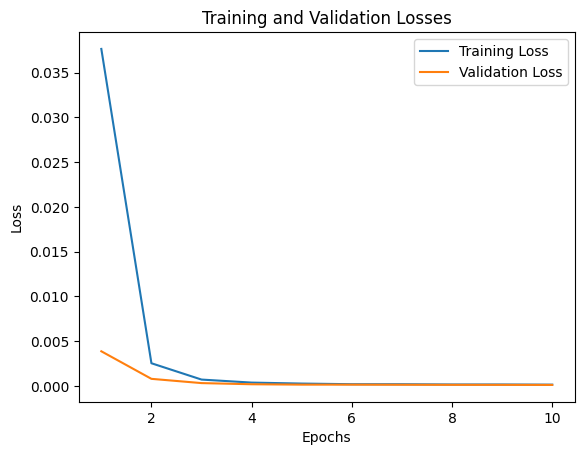

In [88]:
import matplotlib.pyplot as plt

epochs = range(1, args.epochs + 1)

plt.plot(epochs, training_losses, label='Training Loss')
plt.plot(epochs, validation_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Losses')
plt.savefig('losses_plot_hsvcolornet_img_s.png')
plt.show()